## Certified privacy- and unlearning-safe training on the OCT-MNIST dataset

Run over different privacy and unlearning parameters and plot the results

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
import opacus
import copy
import logging
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import unlearning
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

# opacus doesn't respect my logging handler :(
logger = logging.getLogger("abstract_gradient_training")
logger.handlers.clear()

In [2]:
def get_epsilon_delta(
    config: agt.AGTConfig,
    dl_train: torch.utils.data.DataLoader,
    delta: float = 10e-5,
) -> float:
    """
    For the given model and abstract gradient training config, compute the equivalent epsilon and delta values using
    opacus.

    Args:
        model (torch.nn.Sequential): Neural network model. Must be a torch.nn.Sequential object with dense layers and
            ReLU activations only. The model may have other layers (e.g. convolutional layers) before the dense section,
            but these must be fixed and are not trained. If fixed non-dense layers are provided, then the transform
            function must be set to propagate bounds through these layers.
        config (AGTConfig): Configuration object for the abstract gradient training module. See the configuration module
            for more details.
        dl_train (DataLoader): Training data loader.
        delta (float, optional): Desired delta value for the privacy calculation. Defaults to 10e-5.

    Returns:
        float: The epsilon value for the given model and config.
    """

    # get the config variables
    device = config.device
    lr_decay = config.lr_decay
    lr_min = config.lr_min
    dp_sgd_sigma = config.dp_sgd_sigma
    clipping = config.clip_gamma
    learning_rate = config.learning_rate
    n_epochs = config.n_epochs
    batchsize = next(iter(dl_train))[0].size(0)
    model = DeepMindSmall(1, 1).to(device)

    if config.loss == "binary_cross_entropy":
        criterion = torch.nn.BCELoss()
    else:
        raise NotImplementedError(f"Loss function {config.loss} not implemented for eps-delta calculation.")

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    privacy_engine = opacus.PrivacyEngine(accountant="rdp")
    model_private, optimizer_private, data_loader_private = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=dl_train,
        noise_multiplier=dp_sgd_sigma,
        max_grad_norm=clipping,
        poisson_sampling=False,
    )

    def get_lr(epoch):
        lr = max(1 / (1 + lr_decay * epoch), lr_min / learning_rate)
        return lr

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_private, get_lr)

    for _ in range(n_epochs):
        for i, (x, u) in enumerate(dl_train):
            # AGT only takes full batches
            if u.size(0) < batchsize:
                break
            u, x = u.to(device), x.to(device)
            output = model_private(x)
            loss = criterion(output.squeeze().float(), u.squeeze().float())
            # Backward and optimize
            optimizer_private.zero_grad()
            loss.backward()
            optimizer_private.step()
            scheduler.step()

    # compute privacy guarantees
    epsilon = privacy_engine.accountant.get_epsilon(delta=delta)
    return epsilon


In [3]:
# set plotting options
sns.set_theme(context="poster", style="whitegrid", font_scale=1.7)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"][::-1]
fontsize = "large"
seed = 2
results_dir = ".results/"
notebook_id = f"oct_sweep_v4_{seed}"
model_path = ".models/medmnist.ckpt"  # pretrained model path
draft = True  # whether to compute the full suite of results or a quicker reduced version
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [4]:
batchsize = 5000
nominal_config = AGTConfig(
    fragsize=200,
    learning_rate=0.2,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=1.0,
    dp_sgd_sigma=2.0,
    lr_min=0.001,
    early_stopping=False,
    metadata=f"model={model_path}"
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3])
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2])
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000)

09/24/2024 02:28:37:WARNING:k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


In [5]:
# compute pre-trained model accuracy
pretrain_acc = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_all = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_other = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Pre-trained accuracy on Drusen: {pretrain_acc:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on all classes:  {pretrain_acc_all:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on classes 0, 1, 3:  {pretrain_acc_other:.3g}", file=sys.stderr)

# perform one certified training run with to check the nominal accuracy we get
config = copy.deepcopy(nominal_config)
config.k_private = 1
config.clip_gamma = 2.0
config.dp_sgd_sigma = 0.0
torch.manual_seed(seed)
param_l, param_n, param_u = agt.privacy_certified_training(
    model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
)

# compute the accuracies of the fine-tuned model
finetune_acc = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_all = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_other = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Fine-tuned accuracy on Drusen: {finetune_acc:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on all classes: {finetune_acc_all:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on classes 0, 1, 3: {finetune_acc_other:.3g}", file=sys.stderr)

percent_certified = test_metrics.proportion_certified(
    param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)
print(f"Fine-tuned percent certified on all classes: {percent_certified:.3g}", file=sys.stderr)

del param_l, param_n, param_u
torch.cuda.empty_cache()

print(get_epsilon_delta(config, dl_train, delta=10e-5))

Pre-trained accuracy on Drusen: 0.456
Pre-trained accuracy on all classes:  0.835
Pre-trained accuracy on classes 0, 1, 3:  0.961
09/24/2024 02:28:45:INFO:=================== Starting Privacy Certified Training ===================
09/24/2024 02:28:45:DEBUG:	Privacy parameters: k_private=1, clip_gamma=2.0, dp_sgd_sigma=0.0
09/24/2024 02:28:45:DEBUG:	Bounding methods: forward=interval, backward=interval
09/24/2024 02:28:45:INFO:Starting epoch 1
09/24/2024 02:28:45:DEBUG:Initialising dataloader batchsize to 5000
09/24/2024 02:28:45:INFO:Training batch 1: Network eval bounds=(0.46, 0.46, 0.46), W0 Bound=0.0 
09/24/2024 02:28:46:INFO:Training batch 2: Network eval bounds=(0.89, 0.9 , 0.91), W0 Bound=0.0933 
09/24/2024 02:28:47:INFO:Training batch 3: Network eval bounds=(0.85, 0.86, 0.86), W0 Bound=0.143 
09/24/2024 02:28:48:DEBUG:Skipping batch 4 in epoch 1 (expected batchsize 5000, got 508)
09/24/2024 02:28:48:INFO:Starting epoch 2
09/24/2024 02:28:48:INFO:Training batch 4: Network eval bo

inf


/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


In [9]:
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    param_l = [p.to(nominal_config.device) for p in param_l]
    param_n = [p.to(nominal_config.device) for p in param_n]
    param_u = [p.to(nominal_config.device) for p in param_u]
    nominal_accuracy = test_metrics.test_accuracy(
        param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
    )[1]
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return nominal_accuracy, percent_certified

In [19]:
clip_gammas = [0.5, 1.0, 2.0]
sigmas = [0.1, 1.0, 2.0]
privacy_results = {}
epsilons = {}

for sigma in sigmas:
    privacy_results[sigma] = {}
    for gamma in clip_gammas:
        config = copy.deepcopy(nominal_config)
        config.k_private = 1
        config.clip_gamma = gamma
        config.dp_sgd_sigma = sigma
        nom, cert = run_with_config(config)
        privacy_results[sigma][gamma] = (nom, cert)

    epsilons[sigma] = get_epsilon_delta(config, dl_train, delta=10e-5)

In [22]:
for sigma in sigmas:
    print(f"============== sigma={sigma}, epsilon={epsilons[sigma]:.3g}============== ")
    for gamma in clip_gammas:
        print(f"gamma={gamma}, nominal={privacy_results[sigma][gamma][0]:.3g}, certified={privacy_results[sigma][gamma][1]:.3g}, effective_eps={(1 - privacy_results[sigma][gamma][1]) * epsilons[sigma]:.3g}")

============== sigma=0.1, epsilon=328============== 
gamma=0.5, nominal=0.884, certified=0.994, effective_eps=1.97
gamma=1.0, nominal=0.87, certified=0.973, effective_eps=8.86
gamma=2.0, nominal=0.868, certified=0.933, effective_eps=22
============== sigma=1.0, epsilon=4.71============== 
gamma=0.5, nominal=0.878, certified=0.99, effective_eps=0.0471
gamma=1.0, nominal=0.861, certified=0.975, effective_eps=0.118
gamma=2.0, nominal=0.821, certified=0.953, effective_eps=0.222
============== sigma=2.0, epsilon=1.53============== 
gamma=0.5, nominal=0.862, certified=0.983, effective_eps=0.026
gamma=1.0, nominal=0.814, certified=0.982, effective_eps=0.0276
gamma=2.0, nominal=0.743, certified=0.964, effective_eps=0.0551


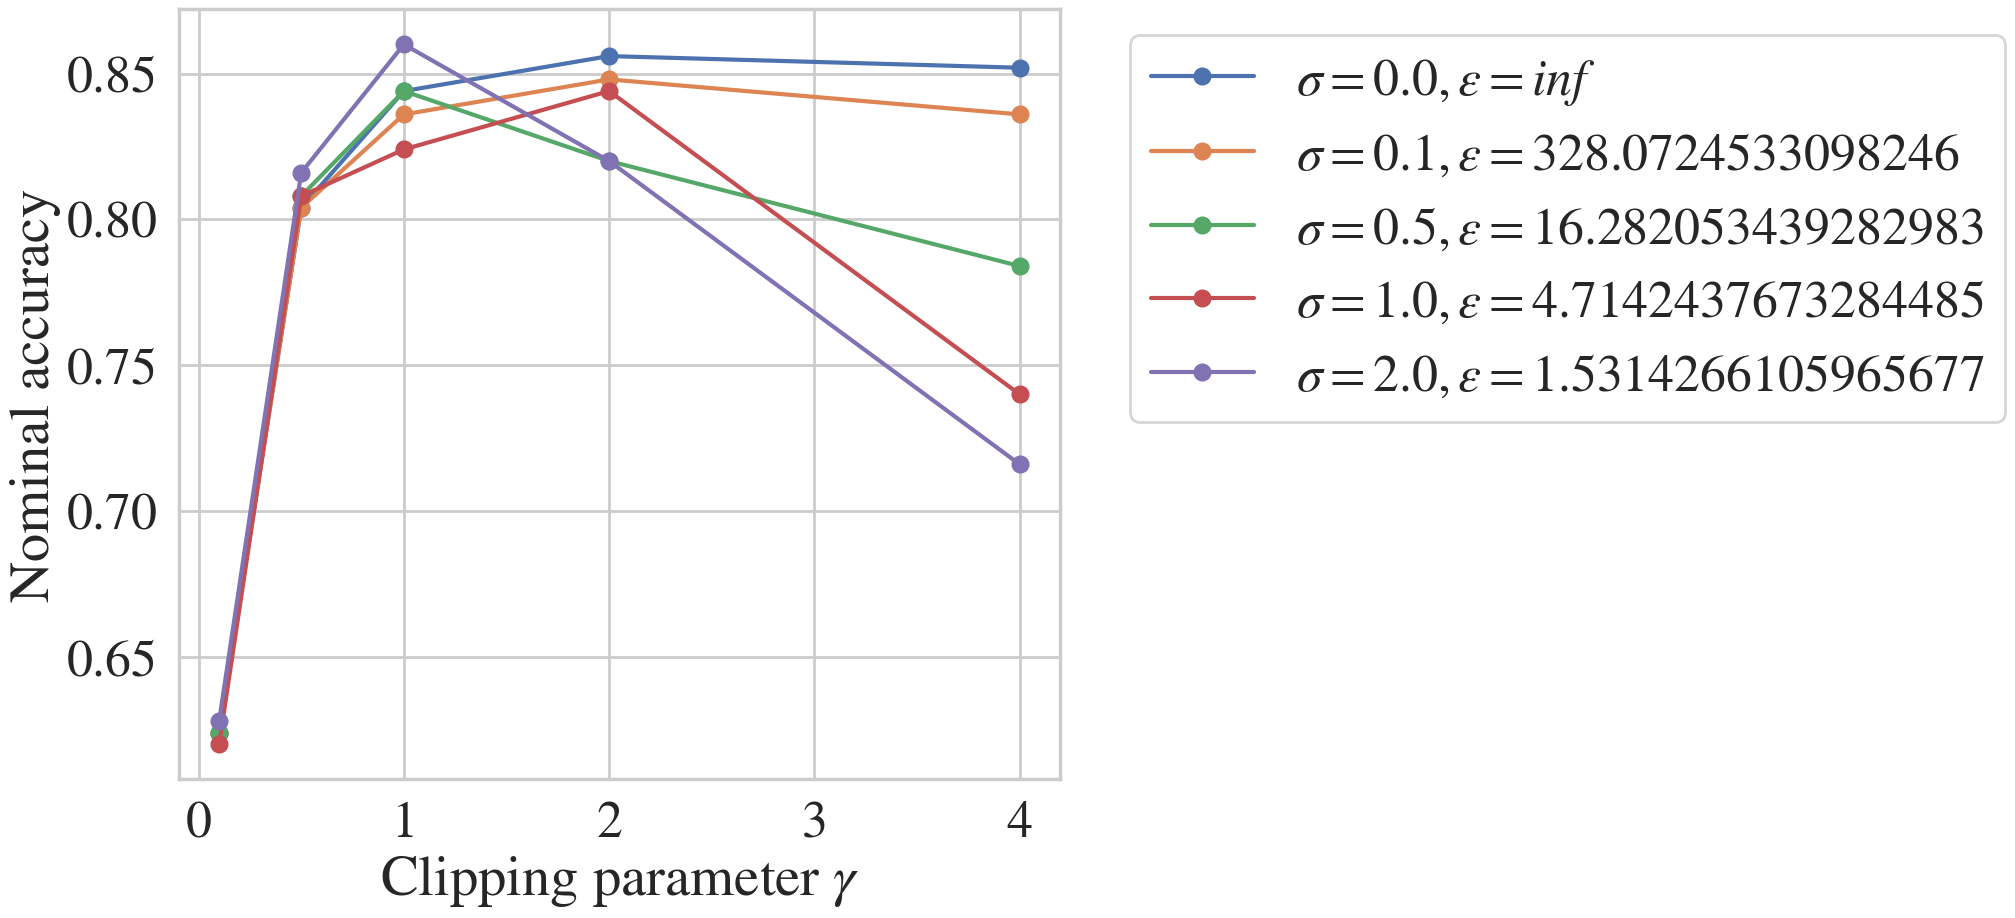

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
axs[1].set_visible(False)
for sigma in sigmas:
    noms = [privacy_results[sigma][gamma][0] for gamma in clip_gammas]
    axs[0].plot(clip_gammas, noms, label=f"$\sigma={sigma}, \epsilon={epsilons[sigma]}$", marker="o")

axs[0].set_ylabel("Nominal accuracy")
axs[0].set_xlabel("Clipping parameter $\gamma$")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')